In [1]:
#Reading in the required libraries
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as img

from skimage import io
from skimage import color
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf

%matplotlib inline

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


In [4]:
#Reading in the CSV
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")
print("Training Data:",train_df.shape)
print("Test Data    :",test_df.shape)
train_df.head()

Training Data: (6800, 2)
Test Data    : (200, 2)


,ID,RESULT
0,Tuberculosis-1017,1
1,Normal-2255,0
2,Tuberculosis-3366,1
3,Normal-246,0
4,Normal-1252,0


In [5]:
# Reading the image, converting it to grayscale and reducing the size to 128 x 128  
num_images         = 6800
im_size            = 224
path_to_img_folder = "Images"

N = train_df.shape[0]
x_train = np.empty((num_images, im_size, im_size), dtype=np.float32)

for i, image_id in enumerate(train_df['ID']):
    img = color.rgb2gray(io.imread(f'{path_to_img_folder}/{image_id}.png'))
    x_train[i, :, :] = resize(img, (im_size, im_size))

<ipython-input-5-64f49fa802ba>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = color.rgb2gray(io.imread(f'{path_to_img_folder}/{image_id}.png'))


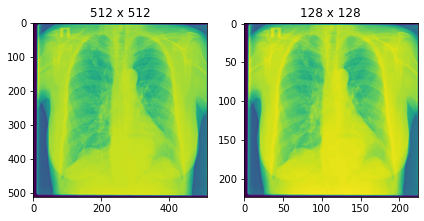

In [6]:
#Plotting the difference in images after reducing the pixels
id = train_df['ID'][0]
fig, (ax1, ax2) = plt.subplots(1, 2)
    
ax1.imshow(io.imread(f'{path_to_img_folder}/{id}.png'))
ax1.set_title("512 x 512")
ax2.imshow(x_train[0,:,:])
ax2.set_title("128 x 128")
fig.tight_layout()

In [7]:
y_train = pd.get_dummies(train_df['RESULT']).values

In [8]:
#Splitting the images to 80/20 train/test
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=0)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(5440, 224, 224)
(1360, 224, 224)
(5440, 2)
(1360, 2)


In [9]:
rgb_train = np.repeat(X_train[..., np.newaxis], 3, -1)
rgb_val = np.repeat(X_test[..., np.newaxis], 3, -1)

In [10]:
BATCH_SIZE = 8

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [11]:
data_generator = create_datagen().flow(rgb_train,y_train, batch_size=BATCH_SIZE, seed=0)

In [12]:
densenet = DenseNet121(
    weights='E:/Project/DenseNet/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [13]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=3,
    validation_data=(rgb_val, y_test)
)